In [1]:
import numpy as np
import pandas as pd 
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2

from tqdm import tqdm

from sklearn.model_selection import KFold
import time


In [2]:


x_train = []
x_test = []
y_train = []

df_train = pd.read_csv('./train_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))


In [3]:

labels = ['blow_down',
          'bare_ground',
          'conventional_mine',
          'blooming',
          'cultivation',
          'artisinal_mine',
          'haze',
          'primary',
          'slash_burn',
          'habitation',
          'clear',
          'road',
          'selective_logging',
          'partly_cloudy',
          'agriculture',
          'water',
          'cloudy']

label_map = {'agriculture': 14,
             'artisinal_mine': 5,
             'bare_ground': 1,
             'blooming': 3,
             'blow_down': 0,
             'clear': 10,
             'cloudy': 16,
             'conventional_mine': 2,
             'cultivation': 4,
             'habitation': 9,
             'haze': 6,
             'partly_cloudy': 13,
             'primary': 7,
             'road': 11,
             'selective_logging': 12,
             'slash_burn': 8,
             'water': 15}


In [4]:

for f, tags in tqdm(df_train.values[:9800], miniters=1000):
    img = cv2.imread('./train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(cv2.resize(img, (128, 128)))
    y_train.append(targets)


y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32) / 255.

print(x_train.shape)
print(y_train.shape)


100%|██████████| 9800/9800 [00:20<00:00, 479.95it/s]


(9800, 128, 128, 3)
(9800, 17)


In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import fbeta_score

X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print('Training data shape:', X_train.shape, Y_train.shape)
print('Validation data shape:', X_valid.shape, Y_valid.shape)

kfold_weights_path = os.path.join('', 'weights.keras')

from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Training data shape: (7840, 128, 128, 3) (7840, 17)
Validation data shape: (1960, 128, 128, 3) (1960, 17)


In [7]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0)
]

model.fit(x=X_train, y=Y_train, validation_data=(X_valid, Y_valid),
          batch_size=128, verbose=1, epochs=30, callbacks=callbacks,
          shuffle=True)

print(model.summary())

if os.path.isfile(kfold_weights_path):
    model.load_weights(kfold_weights_path)

p_valid = model.predict(X_valid, batch_size=128, verbose=2)
print("F beta score: " + str(fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples')))

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 56s 749ms/step - accuracy: 0.3800 - loss: 0.4059 - val_accuracy: 0.7240 - val_loss: 0.2578
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 700ms/step - accuracy: 0.7116 - loss: 0.2711 - val_accuracy: 0.7240 - val_loss: 0.2583
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 703ms/step - accuracy: 0.7153 - loss: 0.2683 - val_accuracy: 0.7240 - val_loss: 0.2581


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,548,056 (17.35 MB)

 Trainable params: 166,161 (649.07 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 332,324 (1.27 MB)

None
16/16 - 13s - 786ms/step
F beta score: 0.6711610353772046


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0]
Predicted Classes: ['primary', 'clear', 'road', 'agriculture']


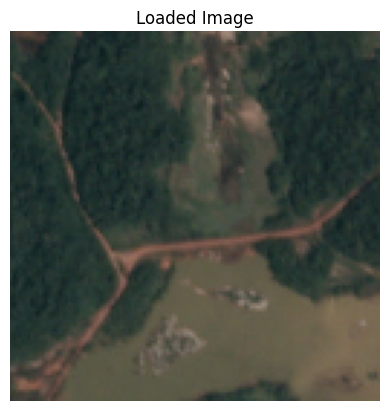

In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = './train-jpg/train_9869.jpg'  
img = image.load_img(img_path, target_size=(128, 128))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array /= 255.0 

predictions = model.predict(img_array)
predicted_classes = (predictions > 0.5).astype(int)[0] 
print(predicted_classes)
class_names = [labels[i] for i in range(len(predicted_classes)) if  predicted_classes[i] > 0]
print("Predicted Classes:", class_names)


plt.imshow(img)
plt.axis('off') 
plt.title('Loaded Image')
plt.show()